🔬 MASK DIAGNOSTIC TOOL

1. Running fast check...
⚡ FAST MASK CHECK

📁 File: task_0001.png
  Shape: (576, 704)
  Exact match: 93.81%
  Unique classes: A=8, B=8
  Background %: A=14.2%, B=11.5%

📁 File: task_0002.png
  Shape: (576, 704)
  Exact match: 94.55%
  Unique classes: A=8, B=8
  Background %: A=14.4%, B=11.7%

📁 File: task_0003.png
  Shape: (576, 704)
  Exact match: 87.77%
  Unique classes: A=9, B=8
  Background %: A=25.4%, B=25.7%

2. Running quick check...
🔍 QUICK MASK QUALITY CHECK
----------------------------------------

📸 Image 1: task_0001.png
  Shape: (576, 704)
  Exact match: 0.9381 (93.81%)
  Unique classes - A: 8, B: 8

📸 Image 2: task_0002.png
  Shape: (576, 704)
  Exact match: 0.9455 (94.55%)
  Unique classes - A: 8, B: 8

📸 Image 3: task_0003.png
  Shape: (576, 704)
  Exact match: 0.8777 (87.77%)
  Unique classes - A: 9, B: 8

3. Running detailed batch analysis...
Found 20 common files

################################################################################

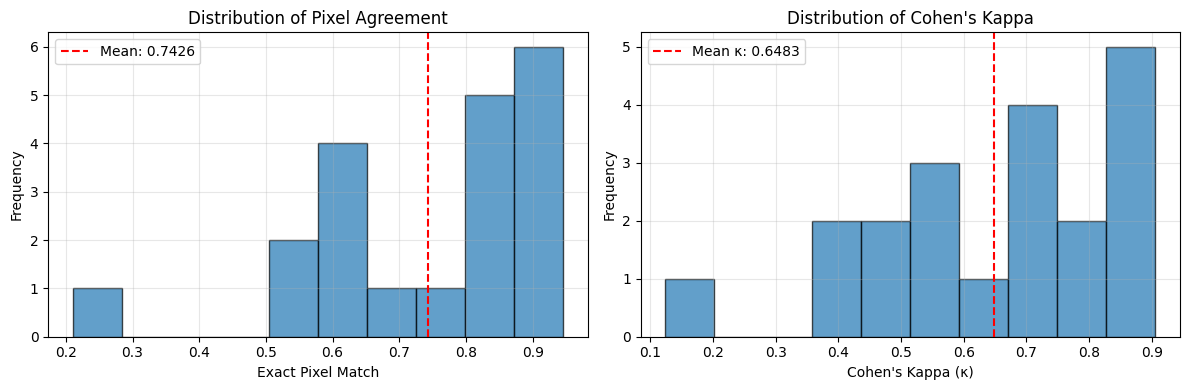


✅ Diagnostic complete!


In [13]:
##### import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from scipy import stats
import os

# ==========================
# DIAGNOSTIC FUNCTIONS
# ==========================

def load_mask_safe(path, expected_classes=12):
    """Safely load mask with validation."""
    try:
        mask = np.array(Image.open(path))
        
        # Check for anomalies
        unique_values = np.unique(mask)
        min_val, max_val = unique_values.min(), unique_values.max()
        
        if min_val < 0 or max_val >= expected_classes:
            print(f"⚠ {os.path.basename(path)}: Values out of range [{min_val}, {max_val}]")
        
        if len(unique_values) < 2:
            print(f"⚠ {os.path.basename(path)}: Only {len(unique_values)} class(es)")
            
        return mask
    except Exception as e:
        print(f"❌ Error loading {path}: {e}")
        return None

def mask_detailed_diagnostic(mask_a, mask_b, img_name, num_classes=12):
    """Run comprehensive diagnostics on two masks."""
    
    print(f"\n{'='*60}")
    print(f"DIAGNOSTICS: {img_name}")
    print('='*60)
    
    # 1. Basic shape validation
    print(f"1. Shape Check:")
    print(f"   Mask A: {mask_a.shape}, Mask B: {mask_b.shape}")
    if mask_a.shape != mask_b.shape:
        print(f"   ❌ SHAPE MISMATCH!")
        return False
    
    # 2. Pixel value range
    print(f"\n2. Value Range:")
    unique_a = np.unique(mask_a)
    unique_b = np.unique(mask_b)
    print(f"   Mask A values: {unique_a} (min={mask_a.min()}, max={mask_a.max()})")
    print(f"   Mask B values: {unique_b} (min={mask_b.min()}, max={mask_b.max()})")
    
    # 3. Class distribution
    print(f"\n3. Class Distribution:")
    counts_a = np.bincount(mask_a.flatten(), minlength=num_classes)
    counts_b = np.bincount(mask_b.flatten(), minlength=num_classes)
    
    for cls in range(num_classes):
        percent_a = counts_a[cls] / mask_a.size * 100
        percent_b = counts_b[cls] / mask_b.size * 100
        if counts_a[cls] > 0 or counts_b[cls] > 0:
            print(f"   Class {cls:2d}: A={counts_a[cls]:8d} ({percent_a:6.2f}%) | "
                  f"B={counts_b[cls]:8d} ({percent_b:6.2f}%)")
    
    # 4. Exact pixel agreement
    exact_match = np.mean(mask_a == mask_b)
    print(f"\n4. Exact Pixel Agreement:")
    print(f"   {exact_match:.6f} ({exact_match*100:.4f}%)")
    
    # 5. Agreement by class (excluding background if class 0)
    print(f"\n5. Agreement by Class (excluding background):")
    for cls in range(1, num_classes):
        mask_a_cls = (mask_a == cls)
        mask_b_cls = (mask_b == cls)
        
        if mask_a_cls.any() or mask_b_cls.any():
            intersection = np.sum(mask_a_cls & mask_b_cls)
            union = np.sum(mask_a_cls | mask_b_cls)
            iou = intersection / union if union > 0 else 0
            
            print(f"   Class {cls:2d}: IoU={iou:.4f}, "
                  f"A={mask_a_cls.sum():6d}, B={mask_b_cls.sum():6d}")
    
    # 6. Confusion matrix analysis
    print(f"\n6. Confusion Matrix Analysis:")
    flat_a = mask_a.flatten()
    flat_b = mask_b.flatten()
    
    conf_mat = np.zeros((num_classes, num_classes), dtype=np.int64)
    for c1, c2 in zip(flat_a, flat_b):
        conf_mat[c1, c2] += 1
    
    # Find major disagreements
    disagreements = []
    for i in range(num_classes):
        for j in range(num_classes):
            if i != j and conf_mat[i, j] > 100:  # More than 100 pixels disagree
                disagreements.append((i, j, conf_mat[i, j]))
    
    if disagreements:
        print(f"   Major Disagreements (>100 pixels):")
        for i, j, count in sorted(disagreements, key=lambda x: x[2], reverse=True)[:5]:
            print(f"   Class {i}→{j}: {count} pixels")
    
    # 7. Statistical tests
    print(f"\n7. Statistical Tests:")
    
    # Calculate Cohen's Kappa
    total = conf_mat.sum()
    if total > 0:
        po = np.trace(conf_mat) / total
        row_sums = conf_mat.sum(axis=1)
        col_sums = conf_mat.sum(axis=0)
        pe = np.sum(row_sums * col_sums) / (total ** 2)
        
        if pe < 1:
            kappa = (po - pe) / (1 - pe)
            print(f"   Cohen's Kappa: κ={kappa:.6f}")
        else:
            print(f"   Cohen's Kappa: undefined (pe=1)")
    
    # Chi-square test - handle zero expected frequencies
    try:
        # Remove rows/columns that are all zeros
        non_zero_rows = np.any(conf_mat > 0, axis=1)
        non_zero_cols = np.any(conf_mat > 0, axis=0)
        non_zero_mask = non_zero_rows & non_zero_cols
        
        if np.sum(non_zero_mask) >= 2:  # Need at least 2 classes
            conf_mat_reduced = conf_mat[non_zero_mask][:, non_zero_mask]
            chi2, p, dof, expected = stats.chi2_contingency(conf_mat_reduced)
            print(f"   Chi-square test (reduced): χ²={chi2:.2f}, p={p:.6f}, df={dof}")
        else:
            print(f"   Chi-square test: Not enough non-zero classes")
    except Exception as e:
        print(f"   Chi-square test: Could not compute - {str(e)[:100]}")
    
    return True

def visualize_mask_comparison(mask_a, mask_b, img_name):
    """Create visualization for mask comparison."""
    
    fig, axes = plt.subplots(2, 3, figsize=(15, 10))
    fig.suptitle(f'Mask Analysis: {img_name}', fontsize=16)
    
    # Use matplotlib's tab20 colormap
    cmap = plt.cm.get_cmap('tab20', 12)
    
    # Plot 1: Mask A
    ax = axes[0, 0]
    im1 = ax.imshow(mask_a, cmap=cmap, vmin=0, vmax=11)
    ax.set_title('Mask A')
    ax.axis('off')
    plt.colorbar(im1, ax=ax, fraction=0.046, pad=0.04)
    
    # Plot 2: Mask B
    ax = axes[0, 1]
    im2 = ax.imshow(mask_b, cmap=cmap, vmin=0, vmax=11)
    ax.set_title('Mask B')
    ax.axis('off')
    plt.colorbar(im2, ax=ax, fraction=0.046, pad=0.04)
    
    # Plot 3: Difference mask
    ax = axes[0, 2]
    diff_mask = mask_a != mask_b
    im3 = ax.imshow(diff_mask, cmap='Reds')
    ax.set_title(f'Differences (Total: {diff_mask.sum()} pixels)')
    ax.axis('off')
    plt.colorbar(im3, ax=ax, fraction=0.046, pad=0.04)
    
    # Plot 4: Class distribution comparison
    ax = axes[1, 0]
    counts_a = np.bincount(mask_a.flatten(), minlength=12)
    counts_b = np.bincount(mask_b.flatten(), minlength=12)
    
    x = np.arange(12)
    width = 0.35
    ax.bar(x - width/2, counts_a, width, label='Mask A', alpha=0.7)
    ax.bar(x + width/2, counts_b, width, label='Mask B', alpha=0.7)
    ax.set_xlabel('Class ID')
    ax.set_ylabel('Pixel Count')
    ax.set_title('Class Distribution')
    ax.legend()
    ax.grid(True, alpha=0.3)
    
    # Plot 5: Agreement heatmap
    ax = axes[1, 1]
    flat_a = mask_a.flatten()
    flat_b = mask_b.flatten()
    
    conf_mat = np.zeros((12, 12), dtype=np.int64)
    for c1, c2 in zip(flat_a, flat_b):
        conf_mat[c1, c2] += 1
    
    # Normalize by row
    conf_mat_norm = conf_mat / conf_mat.sum(axis=1, keepdims=True).clip(min=1e-10)
    
    im5 = ax.imshow(conf_mat_norm, cmap='YlOrRd')
    ax.set_xlabel('Mask B Class')
    ax.set_ylabel('Mask A Class')
    ax.set_title('Normalized Confusion Matrix')
    plt.colorbar(im5, ax=ax, fraction=0.046, pad=0.04)
    
    # Plot 6: Class-wise IoU
    ax = axes[1, 2]
    ious = []
    for cls in range(1, 12):  # Skip background
        mask_a_cls = (mask_a == cls)
        mask_b_cls = (mask_b == cls)
        
        intersection = np.sum(mask_a_cls & mask_b_cls)
        union = np.sum(mask_a_cls | mask_b_cls)
        iou = intersection / union if union > 0 else 0
        ious.append(iou)
    
    ax.bar(range(1, 12), ious)
    ax.set_xlabel('Class ID')
    ax.set_ylabel('IoU')
    ax.set_title('Class-wise IoU (excluding background)')
    ax.set_ylim([0, 1])
    ax.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()

def batch_analysis(folder_a, folder_b, num_classes=12):
    """Run batch analysis on all images."""
    
    # Get common files
    common_files = []
    for ext in ['.png', '.jpg', '.tiff']:
        files_a = {f for f in os.listdir(folder_a) if f.endswith(ext)}
        files_b = {f for f in os.listdir(folder_b) if f.endswith(ext)}
        common_files.extend(sorted(list(files_a & files_b)))
    
    print(f"Found {len(common_files)} common files")
    
    results = []
    for fname in common_files:
        print(f"\n{'#'*80}")
        print(f"PROCESSING: {fname}")
        print('#'*80)
        
        path_a = os.path.join(folder_a, fname)
        path_b = os.path.join(folder_b, fname)
        
        mask_a = load_mask_safe(path_a, num_classes)
        mask_b = load_mask_safe(path_b, num_classes)
        
        if mask_a is None or mask_b is None:
            continue
        
        # Run diagnostics
        is_valid = mask_detailed_diagnostic(mask_a, mask_b, fname, num_classes)
        
        if is_valid:
            # Calculate metrics
            exact_match = np.mean(mask_a == mask_b)
            
            # Calculate Cohen's Kappa
            flat_a = mask_a.flatten()
            flat_b = mask_b.flatten()
            conf_mat = np.zeros((num_classes, num_classes), dtype=np.int64)
            for c1, c2 in zip(flat_a, flat_b):
                conf_mat[c1, c2] += 1
            
            total = conf_mat.sum()
            po = np.trace(conf_mat) / total
            row_sums = conf_mat.sum(axis=1)
            col_sums = conf_mat.sum(axis=0)
            pe = np.sum(row_sums * col_sums) / (total ** 2)
            
            if pe < 1:
                kappa = (po - pe) / (1 - pe)
            else:
                kappa = 1.0
            
            results.append({
                'image': fname,
                'exact_match': exact_match,
                'kappa': kappa,
                'po': po,
                'pe': pe
            })
            
            # Visualize (optional - can be slow for many images)
            # Uncomment if you want to see each image
            # visualize_mask_comparison(mask_a, mask_b, fname)
    
    # Summary statistics
    if results:
        print(f"\n{'='*80}")
        print("BATCH SUMMARY STATISTICS")
        print('='*80)
        
        exact_matches = [r['exact_match'] for r in results]
        kappas = [r['kappa'] for r in results]
        
        print(f"Total images analyzed: {len(results)}")
        print(f"\nExact Match (pixel agreement):")
        print(f"  Mean: {np.mean(exact_matches):.6f} ({np.mean(exact_matches)*100:.4f}%)")
        print(f"  Std:  {np.std(exact_matches):.6f}")
        print(f"  Range: [{np.min(exact_matches):.6f}, {np.max(exact_matches):.6f}]")
        
        print(f"\nCohen's Kappa:")
        print(f"  Mean: {np.mean(kappas):.6f}")
        print(f"  Std:  {np.std(kappas):.6f}")
        print(f"  Range: [{np.min(kappas):.6f}, {np.max(kappas):.6f}]")
        
        # Create summary visualization
        fig, axes = plt.subplots(1, 2, figsize=(12, 4))
        
        # Plot 1: Exact match distribution
        axes[0].hist(exact_matches, bins=10, edgecolor='black', alpha=0.7)
        axes[0].axvline(np.mean(exact_matches), color='red', linestyle='--', 
                       label=f'Mean: {np.mean(exact_matches):.4f}')
        axes[0].set_xlabel('Exact Pixel Match')
        axes[0].set_ylabel('Frequency')
        axes[0].set_title('Distribution of Pixel Agreement')
        axes[0].legend()
        axes[0].grid(True, alpha=0.3)
        
        # Plot 2: Kappa distribution
        axes[1].hist(kappas, bins=10, edgecolor='black', alpha=0.7)
        axes[1].axvline(np.mean(kappas), color='red', linestyle='--', 
                       label=f'Mean κ: {np.mean(kappas):.4f}')
        axes[1].set_xlabel("Cohen's Kappa (κ)")
        axes[1].set_ylabel('Frequency')
        axes[1].set_title('Distribution of Cohen\'s Kappa')
        axes[1].legend()
        axes[1].grid(True, alpha=0.3)
        
        plt.tight_layout()
        plt.show()
        
        # Return results for further analysis
        return results
    else:
        print("No valid results to analyze")
        return None

def quick_mask_check(folder_a, folder_b, sample_size=3):
    """Quick check of mask quality."""
    
    print("🔍 QUICK MASK QUALITY CHECK")
    print("-" * 40)
    
    # Find image files
    image_files = []
    for ext in ['.png', '.jpg']:
        files_a = {f for f in os.listdir(folder_a) if f.endswith(ext)}
        files_b = {f for f in os.listdir(folder_b) if f.endswith(ext)}
        image_files.extend(sorted(list(files_a & files_b)))
    
    if not image_files:
        print("No common images found!")
        return
    
    # Check first few images
    for i, fname in enumerate(image_files[:sample_size]):
        print(f"\n📸 Image {i+1}: {fname}")
        
        path_a = os.path.join(folder_a, fname)
        path_b = os.path.join(folder_b, fname)
        
        try:
            mask_a = np.array(Image.open(path_a))
            mask_b = np.array(Image.open(path_b))
            
            # Quick metrics
            exact_match = np.mean(mask_a == mask_b)
            unique_a = len(np.unique(mask_a))
            unique_b = len(np.unique(mask_b))
            
            print(f"  Shape: {mask_a.shape}")
            print(f"  Exact match: {exact_match:.4f} ({exact_match*100:.2f}%)")
            print(f"  Unique classes - A: {unique_a}, B: {unique_b}")
            
            # Check if masks are suspiciously similar
            if exact_match > 0.99:
                print(f"  ⚠ WARNING: Masks are >99% identical")
            
            # Check for constant masks
            if unique_a == 1:
                print(f"  ⚠ WARNING: Mask A has only 1 class")
            if unique_b == 1:
                print(f"  ⚠ WARNING: Mask B has only 1 class")
                
        except Exception as e:
            print(f"  ❌ Error: {e}")

# ==========================
# SIMPLIFIED CHECK (FASTEST)
# ==========================

def fast_mask_check(folder_a, folder_b):
    """Ultra-fast check for common mask problems."""
    
    print("⚡ FAST MASK CHECK")
    print("=" * 50)
    
    # Get first 3 PNG files
    files_a = sorted([f for f in os.listdir(folder_a) if f.endswith('.png')])
    files_b = sorted([f for f in os.listdir(folder_b) if f.endswith('.png')])
    
    common_files = sorted(list(set(files_a) & set(files_b)))[:3]
    
    if not common_files:
        print("No common PNG files found!")
        return
    
    for fname in common_files:
        print(f"\n📁 File: {fname}")
        
        path_a = os.path.join(folder_a, fname)
        path_b = os.path.join(folder_b, fname)
        
        try:
            # Load masks
            mask_a = np.array(Image.open(path_a))
            mask_b = np.array(Image.open(path_b))
            
            # Basic checks
            if mask_a.shape != mask_b.shape:
                print(f"  ❌ SHAPE MISMATCH: {mask_a.shape} vs {mask_b.shape}")
                continue
            
            # Exact match percentage
            exact_pct = np.mean(mask_a == mask_b) * 100
            
            # Class counts
            unique_a = np.unique(mask_a)
            unique_b = np.unique(mask_b)
            
            # Background percentage (assuming class 0 is background)
            bg_pct_a = np.sum(mask_a == 0) / mask_a.size * 100
            bg_pct_b = np.sum(mask_b == 0) / mask_b.size * 100
            
            print(f"  Shape: {mask_a.shape}")
            print(f"  Exact match: {exact_pct:.2f}%")
            print(f"  Unique classes: A={len(unique_a)}, B={len(unique_b)}")
            print(f"  Background %: A={bg_pct_a:.1f}%, B={bg_pct_b:.1f}%")
            
            # Red flags
            if exact_pct > 99.9:
                print(f"  🚨 RED FLAG: Masks are >99.9% identical (possible copy)")
            
            if bg_pct_a > 95 or bg_pct_b > 95:
                print(f"  ⚠ WARNING: >95% background (class imbalance)")
                
            if len(unique_a) == 1 or len(unique_b) == 1:
                print(f"  ⚠ WARNING: Only 1 class in mask")
                
        except Exception as e:
            print(f"  ❌ Error: {e}")

# ==========================
# MAIN EXECUTION
# ==========================

if __name__ == "__main__":
    # Configuration - UPDATE THESE PATHS
    FOLDER_A = "/workspace/RGB_T_SAR/proyecto_oct_2025_sam2/dataset/dataset_2025/estadistica/sam2/json_to_png_andres_ii_tir/"
    FOLDER_B = "/workspace/RGB_T_SAR/proyecto_oct_2025_sam2/dataset/dataset_2025/estadistica/sam2/json_to_png_jose_tir/"
    NUM_CLASSES = 12
    
    print("🔬 MASK DIAGNOSTIC TOOL")
    print("=" * 60)
    
    # Option 1: Fast check (recommended first)
    print("\n1. Running fast check...")
    fast_mask_check(FOLDER_A, FOLDER_B)
    
    # Option 2: Quick check
    print("\n2. Running quick check...")
    quick_mask_check(FOLDER_A, FOLDER_B, sample_size=3)
    
    # Option 3: Full analysis (uncomment if needed)
    print("\n3. Running detailed batch analysis...")
    results = batch_analysis(FOLDER_A, FOLDER_B, NUM_CLASSES)
    
    print("\n✅ Diagnostic complete!")

In [34]:
import numpy as np
from sklearn.metrics import cohen_kappa_score

# Simpler test for one image
folder_a = "/workspace/RGB_T_SAR/proyecto_oct_2025_sam2/dataset/dataset_2025/estadistica/poligonos/json_to_png_andres_rgb/"
folder_b = "/workspace/RGB_T_SAR/proyecto_oct_2025_sam2/dataset/dataset_2025/estadistica/sam2/json_to_png_andres_tir/"

# Check first image
fname = "task_0001.png"
mask_a = np.array(Image.open(os.path.join(folder_a, fname)))
mask_b = np.array(Image.open(os.path.join(folder_b, fname)))

# Flatten
flat_a = mask_a.flatten()
flat_b = mask_b.flatten()

# Calculate Kappa for this image
kappa_single = cohen_kappa_score(flat_a, flat_b)
print(f"Single image Kappa for {fname}: {kappa_single:.4f}")

# Now calculate what your global method would give
# (But we only have one image, so it's the same)
print(f"This should be ~0.84, not 0.98")

Single image Kappa for task_0001.png: 0.8397
This should be ~0.84, not 0.98
